# Prelim
This analysis uses the results from `PBMC-multiome-RNA.ipynb` and `PBMC-multiome-ATAC.ipynb`


In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

In [6]:
data_dir = 'data/multiome/'

In [7]:
rna_ad = sc.read(data_dir + 'pbmc_multiome_rna.h5ad')

In [9]:
atac_ad = sc.read(data_dir + 'pbmc_multiome_atac.h5ad')

# Comparisons

## Number of cells

<b> Note: Since ArchR also applies additional filters, it is quite likely that the number of cells in ATAC is less than number of cells in RNA </b>

In [20]:
# Number of cells
rna_ad.shape[0], atac_ad.shape[0]

(11275, 11049)

To keep things consistent, one can subset the RNA Anndata to use the same set of ATAC cells after ATAC processing

## Cluster comparison

In [10]:
atac_obs = 'Clusters'
rna_obs = 'leiden'

rna_by_atac = pd.DataFrame(0.0, index='RNA:' + rna_ad.obs[rna_obs].values.categories, 
                          columns='ATAC:' + atac_ad.obs[atac_obs].values.categories)
for c in rna_by_atac.columns:
    # Cells 
    cells = atac_ad.obs_names['ATAC:' + atac_ad.obs[atac_obs].astype(str) == c]
    
    # Proportions
    proportions = rna_ad.obs[rna_obs][cells].value_counts() / len(cells)
    proportions.index = 'RNA:' + proportions.index.astype(str)
    rna_by_atac.loc[proportions.index, c] = proportions

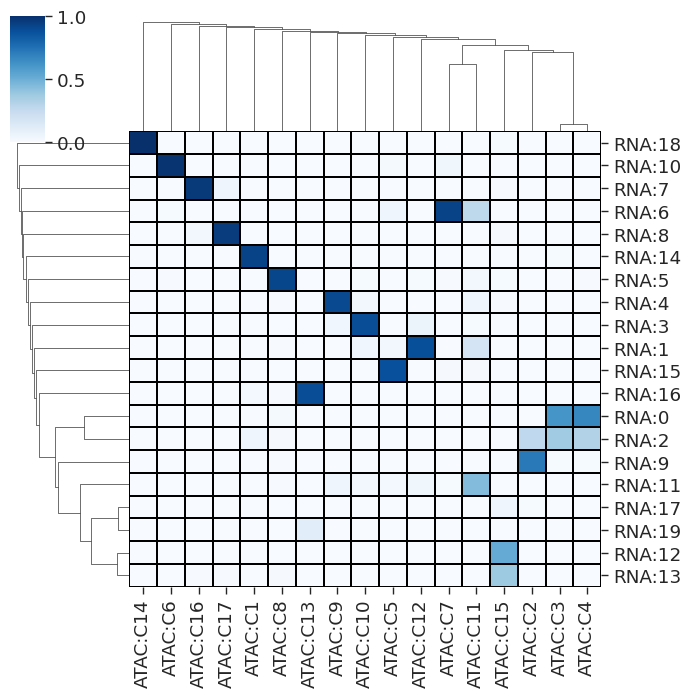

In [ ]:
sns.clustermap(rna_by_atac, cmap=matplotlib.cm.Blues, vmin=0, vmax=1, 
               figsize=[7, 7], linecolor='black', linewidth=0.25, 
               row_cluster=True, col_cluster=True, 
               xticklabels=rna_by_atac.columns, yticklabels=rna_by_atac.index)

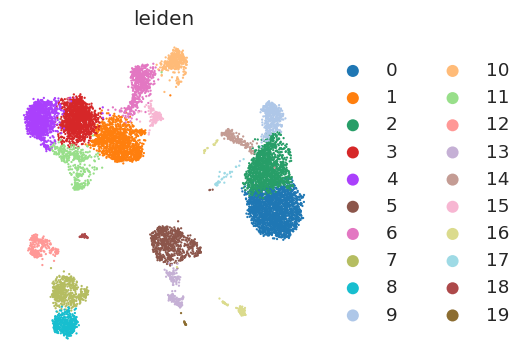

In [14]:
sc.pl.scatter(rna_ad, basis='umap', color='leiden', frameon=False)

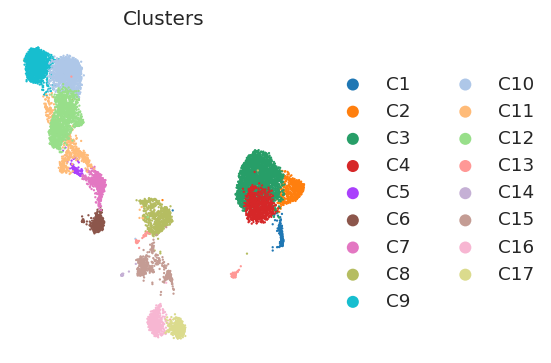

In [17]:
sc.pl.scatter(atac_ad, basis='umap_archr', color='Clusters', frameon=False)

## RNA Subset

In the analysis we will subset RNA anndata to use the same subset as ATAC without reprocessing

In [21]:
rna_sub = rna_ad[atac_ad.obs_names, :]

In [22]:
rna_sub.obs['ATACClusters'] = atac_ad.obs['Clusters']
atac_ad.obs['RNAClusters'] = rna_ad.obs['leiden']

<ipython-input-22-9d13533d8772>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_sub.obs['ATACClusters'] = atac_ad.obs['Clusters']


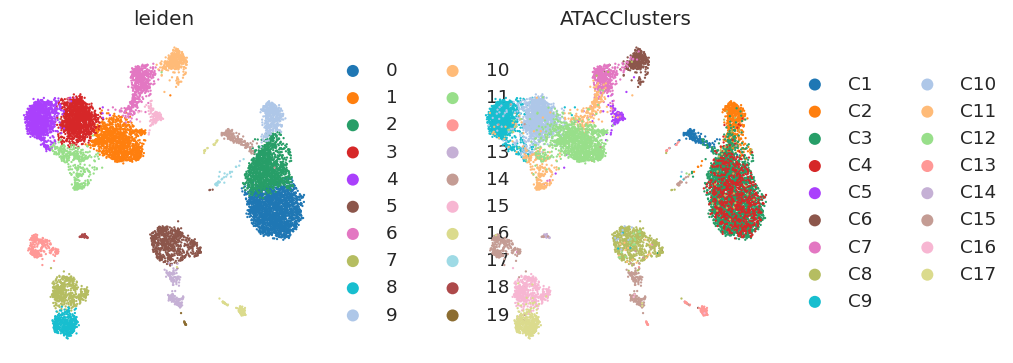

In [24]:
sc.pl.scatter(rna_sub, basis='umap', color=['leiden', 'ATACClusters'], frameon=False)

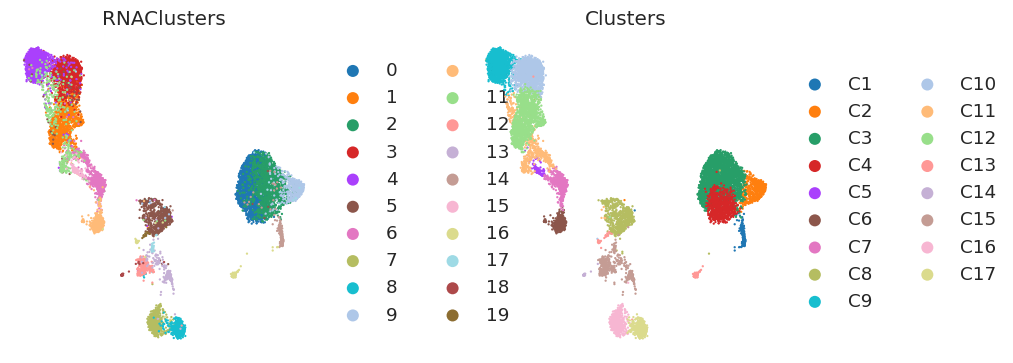

In [25]:
sc.pl.scatter(atac_ad, basis='umap_archr', color=['RNAClusters', 'Clusters'], frameon=False)